In [1]:
# Ben Caruso
# Data visualization and Preprocessing pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import spacy
nlp = spacy.load('en_core_web_md')

import wordcloud as wc
from wordcloud import WordCloud, STOPWORDS

import string

### Read in previously generated text documents

Here I read in the previously created text files by the script Interview Read In Script.ipynb. By doing this, I streamline the process of handling my data, since I now have one less step when it comes to processing my data: I don't have to read in the original word documents and convert the interviewer/interviewee speech to strings every time I want to work with my data

In [2]:
with open("vt_farmer_text.txt",'r') as txt:
    vt_farmer_text = txt.readlines()[0]
with open("vt_expert_text.txt",'r') as txt:
    vt_expert_text = txt.readlines()[0]
with open("me_farmer_text.txt",'r') as txt:
    me_farmer_text = txt.readlines()[0]
with open("me_expert_text.txt",'r') as txt:
    me_expert_text = txt.readlines()[0]

### SpaCy Processing 

**Step 1: Utilize spacy's nlp() function on the bare text**

I use the popular and powerful natural language processing library spaCy to handle the bulk of text processing needs for this project. SpaCy has an incredibly powerful nlp() function call that will call a pipeline of various nlp techniques such as named entity recognition, tokenization, lemmatization, word embedding vectorization, and dependency parsing, to name a few.

In [3]:
# Utilize spacy to process the farmer's text
vt_farmer_doc = nlp(vt_farmer_text)
vt_exp_doc = nlp(vt_expert_text)
me_farmer_doc = nlp(me_farmer_text)
me_exp_doc = nlp(me_expert_text)

In [4]:
# Write a function to display basic entity info:
def show_ents(doc):
    if doc.ents:
        for ent in doc.ents:
            print(ent.text + ' - ' + ent.label_ + ' - ' + 
                  str(spacy.explain(ent.label_)))
    else:
        print("No entities found.")

**Step 2: Define match terms**

For my question, I define several terms I aim to match sentences on as my method of choice for differentiating between passages in which they discuss climate related issues and non-relevant passages

In [5]:
# Match on common terms such as climate change, agriculture
MATCH_TERMS = ['climate change', 'climate', 'agriculture', 'weather', 'hot', 'cold', 'environment']

In [6]:
farmers = nlp(vt_farmer_text + me_farmer_text)
experts = nlp(vt_expert_text + me_expert_text)

*Sidenote*

I played around with finding entity names to see if that could help with prediction. I did not get very far with it, but the code below could behave as starter code to dive deeper into that idea.

In [7]:
# Write a function to display entity info SPECIFIED - only ORGs and LOCs and MONEY:

MATCH_LABELS = ["ORG", "LOC", "MONEY"]

def get_match_ents(doc):
    
    match_terms = []
    
    if doc.ents:
        for ent in doc.ents:
            if ent.label_ in MATCH_LABELS:
                match_terms.append(ent.text + ' - ' + ent.label_ + ' - ' + 
                      str(spacy.explain(ent.label_)))
    else:
        print("No entities found.")
        
    return match_terms

In [8]:
org_terms_f = [term for term in get_match_ents(farmers) if "ORG" in term]
loc_terms_f = [term for term in get_match_ents(farmers) if "LOC" in term]
money_terms_f = [term for term in get_match_ents(farmers) if "MONEY" in term]

org_terms_e = [term for term in get_match_ents(experts) if "ORG" in term]
loc_terms_e = [term for term in get_match_ents(experts) if "LOC" in term]
money_terms_e = [term for term in get_match_ents(experts) if "MONEY" in term]

In [13]:
list(set([org_f for org_e in org_terms_e for org_f in org_terms_f if org_e == org_f]))  

['ag - ORG - Companies, agencies, institutions, etc.',
 'uvm - ORG - Companies, agencies, institutions, etc.',
 'the vermont grass farmers association - ORG - Companies, agencies, institutions, etc.',
 'facebook - ORG - Companies, agencies, institutions, etc.',
 'cornell - ORG - Companies, agencies, institutions, etc.',
 'burlington - ORG - Companies, agencies, institutions, etc.',
 'usda - ORG - Companies, agencies, institutions, etc.',
 'the farm bureau - ORG - Companies, agencies, institutions, etc.',
 'the vermont beef producers association - ORG - Companies, agencies, institutions, etc.',
 'noaa - ORG - Companies, agencies, institutions, etc.']

In [14]:
# REMOVE STOPWORDS (TAKEN OUT FOR NOW)
#vt_farmer = [word for word in vt_farmer_doc if not word.is_stop]

In [15]:
#vt_farmer_lemmas = [token.lemma_ for token in vt_farmer]

**Step 3: Lemmatization**

Convert each word in each sentence to its lemmatized form, thus reducing my overall number of features

In [16]:
# Convert the spacy document to a list of lemmatized sentences
# LEMMATIZATION
    
vt_farmer_sents = [sentence.lemma_ for sentence in vt_farmer_doc.sents]
vt_exp_sents = [sentence.lemma_ for sentence in vt_exp_doc.sents]
me_farmer_sents = [sentence.lemma_ for sentence in me_farmer_doc.sents]
me_exp_sents = [sentence.lemma_ for sentence in me_exp_doc.sents]

**Step 4: Remove punctuation**

Remove pointless special characters that will not help my model classify the speaker

In [17]:
# FUNCTION TO REMOVE REDUNDANT PUNCTUATION
def clean_text(text):
    clean_sents = []
    
    for sentence in text:
        sentence_clean = sentence
        for ch in sentence:
            if ch in string.punctuation:
                sentence_clean = sentence_clean.replace(ch, "")
        clean_sents.append(sentence_clean)
        
    return clean_sents

In [18]:
vt_farmer_sents = clean_text(vt_farmer_sents)
vt_exp_sents = clean_text(vt_exp_sents)
me_farmer_sents = clean_text(me_farmer_sents)
me_exp_sents = clean_text(me_exp_sents)

**Step 5: Removal of short sentences**

Sentences that are 3 words are less are highly likely to be merely confirmations and small talk, and so will not be needed

In [19]:
# REMOVE SHORT SENTENCES

vt_farmer_sents = [sent for sent in vt_farmer_sents if len(sent.split(' ')) > 3]
vt_exp_sents = [sent for sent in vt_exp_sents if len(sent.split(' ')) > 3]
me_farmer_sents = [sent for sent in me_farmer_sents if len(sent.split(' ')) > 3]
me_exp_sents = [sent for sent in me_exp_sents if len(sent.split(' ')) > 3]

**Step 6: Removal of PRON**

Lemmatization conerted all pronouns to the same PRON term. I test to see if this preprocessing improves my model fit. 

In [20]:
vt_farmer_sents = [sent.replace("PRON", "") for sent in vt_farmer_sents]
vt_exp_sents = [sent.replace("PRON", "") for sent in vt_exp_sents]
me_farmer_sents = [sent.replace("PRON", "") for sent in me_farmer_sents]
me_exp_sents = [sent.replace("PRON", "") for sent in me_exp_sents]

In [21]:
vt_farmer_sents[5]

' be a pasture raise livestock  livestock operation that focus on grow grass and building soil '

**Step 7: Find Matches**

Now I define a function to find all matches within my sentences to the key terms I've defined

In [22]:
def find_matches(sentence_text):
    # Define match terms
    MATCH_TERMS = ['climate change', 'climate', 'agriculture', 'weather', 'hot', 'cold', 'environment']

    # List of sentences with match
    match_sentences = []

    match = False

    # Go through sentences in the sentences passed in, and pick out the ones that mention the key terms
    for sentence in sentence_text:
        for word in sentence.split(' '):
            if word in MATCH_TERMS:
                match = True
        if match:
            match_sentences.append(sentence)
        match = False
    
    # Returns list of sentences containing a word that is in MATCH_TERMS
    return match_sentences

In [23]:
vt_farmer_match = find_matches(vt_farmer_sents)
vt_exp_match = find_matches(vt_exp_sents)
me_farmer_match = find_matches(me_farmer_sents)
me_exp_match = find_matches(me_exp_sents)

In [24]:
print(f'Length of vt farmer matches: {len(vt_farmer_match)}')
print(f'Length of vt expert matches: {len(vt_exp_match)}')
print(f'Length of me farmer matches: {len(me_farmer_match)}')
print(f'Length of me expert matches: {len(me_exp_match)}')
print('\n')
print(f'Farmer rows: {len(vt_farmer_match) + len(me_farmer_match)}')
print(f'Expert rows: {len(vt_exp_match) + len(me_exp_match)}')

Length of vt farmer matches: 167
Length of vt expert matches: 113
Length of me farmer matches: 100
Length of me expert matches: 81


Farmer rows: 267
Expert rows: 194


Clearly, there is more data from Vermont than there is for Maine, which may be relevant to the study and my model, but also may not. However, there are clearly more passages from farmers than experts, which make sense from a domain knowledge point of view as we have many more interviews for farmers than experts. In order to deal with this when creating my labeled dataset, I will select a random 192 rows from the farmers in order to ensure a 50/50 split, so that evaluation of my model is clear

In [25]:
vt_farmer_match

[' obviously   say that individual weather event be not climate change  but i think  be more likely to see those more severe event because of climate change  right ',
 ' know  and again   ’ hard to blame something like irene on a climate change ',
 'so  for somebody in  situation and the way  come to farming  and all   who i consider  peer  kind of the new way of think about agriculture  that ’ just – allow the cow to go into a stream be antitheta  right ',
 'so i think what ’ work well be that vermont be a very generally educate state about  food  and very supportive of local agriculture ',
 'but i think that that be a real detriment to vermont agriculture  because people who use to have access to restaurant be basically shut out by these big distributor  and by call  local beef ',
 'so anyway  that ’ probably what i see as the problem  and of course  the problem be  have short grow season   do require store forage for much of the year with beef animal and other cattle  and  do not ha

### Make a new dataframe for all farmer/expert sentences

In [26]:
# Create farmer texts dataframe
data_farmer = pd.DataFrame(vt_farmer_sents + me_farmer_sents, columns = ["passage"])
data_farmer['farmer'] = [1 for i in range(len(data_farmer["passage"]))]
# Create expert texts dataframe
data_expert = pd.DataFrame(vt_exp_sents + me_exp_sents, columns = ["passage"])
data_expert['farmer'] = [0 for i in range(len(data_expert["passage"]))]
# Remove periods from passages
data_farmer['passage'] = data_farmer['passage'].str.replace(".", "")
data_expert['passage'] = data_expert['passage'].str.replace(".", "")

# 1 = farmer
# 0 = expert

In [27]:
data_farmer.head()

,passage,farmer
0,oh those mainer do not know anything,1
1,that ’ because use all the resource,1
2,be just like a vacuum,1
3,be in 20th season,1
4,maple wind farm,1


In [107]:
total_data = pd.concat([data_farmer, data_expert], ignore_index = True)
#total_data

In [129]:
# Create dataframe of 192 farmer texts and 192 expert texts
N = 192

total_farmer_sample = data_farmer.sample(n = N, random_state = 0)
total_exp_sample = data_expert.sample(n = N, random_state = 0)

total_df = pd.concat([total_farmer_sample, total_exp_sample], ignore_index = True)

# Shuffle dataset
total_df = total_df.sample(frac = 1)
total_df['farmer'].value_counts()

1    192
0    192
Name: farmer, dtype: int64

### Make a new dataframe with the classified texts

In [109]:
# Right now, the passages are limited to one sentence
# Create farmer match dataframe
data_farmer_match = pd.DataFrame(vt_farmer_match + me_farmer_match, columns = ['passage'])
data_farmer_match['farmer'] = [1 for i in range(len(data_farmer_match['passage']))]
# Create expert match dataframe
data_exp_match = pd.DataFrame(vt_exp_match + me_exp_match, columns = ['passage'])
data_exp_match['farmer'] = [0 for i in range(len(data_exp_match['passage']))]
# Replace periods
data_farmer_match['passage'] = data_farmer_match['passage'].str.replace(".", "")
data_exp_match['passage'] = data_exp_match['passage'].str.replace(".", "")

In [151]:
# Create dataframe of 192 farmer texts and 192 expert texts
N = 192

farmer_match_sample = data_farmer_match.sample(n = N, random_state = 0)

match_df = pd.concat([farmer_match_sample, data_exp_match], axis = 0)

# Shuffle dataset
match_df = match_df.sample(frac = 1)
match_df['farmer'].value_counts()

0    194
1    192
Name: farmer, dtype: int64

Now I have two dataframes of 384 elements - one contains passages from all across the corpus, and the other only contains passages that include the match terms. Each dataframe is a perfect 50/50 split between the classes, for the purpose of ease of model evaluation.

In [152]:
# Reset index
match_df.reset_index(inplace=True)
# Remove old index, keep new one
match_df.drop("index",axis=1,inplace=True)

match_df

,passage,farmer
0,be a pain to keep track of all of those and c...,0
1,farmer have always deal with weather and clima...,0
2,so thing that be work good for agriculture i...,1
3,’ all about climate,1
4,so i think climate for some form of agricultu...,0
...,...,...
381,have do and that be raise bed agriculture,0
382,i just think – i think the more gently – i th...,0
383,so i think what ’ work well be that vermont be...,1
384,well obviously maine agriculture have change...,0


In [154]:
# Reset index
total_df.reset_index(inplace=True)
# Remove old index, keep new one
total_df.drop("index",axis=1,inplace=True)

total_df

,passage,farmer
0,and the ability to destock before get in trou...,1
1,an example of that be that have a meat inspec...,1
2,manageable risk that have control of,1
3,– be bless with the cheap most abundant saf...,1
4,and not only that,1
...,...,...
379,but certainly produce plenty of calorie when ...,1
380,do not want to convert fertile cropland into...,0
381,some of will make the pitch to and many of ...,0
382,but put in a giant compost pile,1


In [84]:
# Read the dataframes out to a csv for future modeling
match_df.to_csv("match_data_nopron.csv")
total_df.to_csv("total_data_nopron.csv")

Now that I have two lists, one with the interviewer's questions and comments, and one with the interviewees' responses, I wish to concatenate these lists aka join them on their common index. As a result, I will have a single list of tuples, in which each tuple contains an interviewer question and the interviewee response. 

### WordClouds

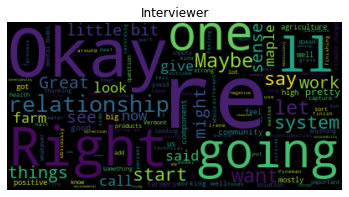

In [150]:
wc = WordCloud(stopwords = set(list(STOPWORDS) + ["think", "Yeah"]), random_state = 42).generate(clean_text)

plt.imshow(wc, interpolation = 'bilinear')
plt.title("Interviewer")
plt.axis("off");

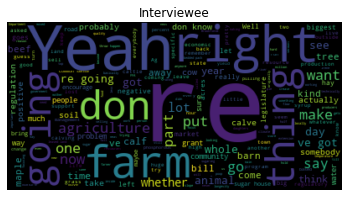

In [30]:
wc = WordCloud(stopwords = set(list(STOPWORDS)), random_state = 42).generate(farmer)

plt.imshow(wc, interpolation = 'bilinear')
plt.title("Interviewee")
plt.axis("off");

#### WordCloud for entire corpus of Vermont Farmer's speech

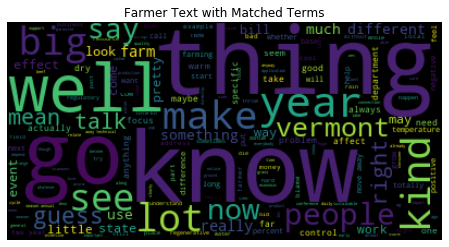

In [133]:
wc = WordCloud(stopwords = set(list(STOPWORDS) + ["think", "yeah", "re", "change"] + MATCH_TERMS), 
               random_state = 42).generate("".join(vt_farmer_match+me_farmer_match))

plt.figure(figsize=(8,4))
plt.imshow(wc, interpolation = 'bilinear')
plt.title("Farmer Text with Matched Terms")
plt.axis("off");

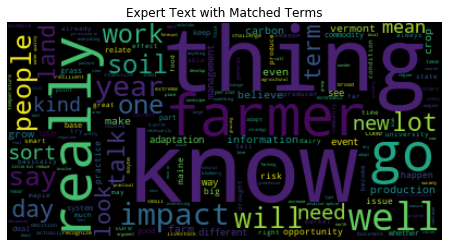

In [134]:
wc = WordCloud(stopwords = set(list(STOPWORDS) + ["think", "yeah", "re", "change"] + MATCH_TERMS), 
               random_state = 42).generate("".join(vt_exp_match+me_exp_match))

plt.figure(figsize=(8,4))
plt.imshow(wc, interpolation = 'bilinear')
plt.title("Expert Text with Matched Terms")
plt.axis("off");

In [155]:
series_vec_match = match_df['passage'].apply(lambda x: nlp(x).vector)
series_vec_total = total_df['passage'].apply(lambda x: nlp(x).vector)

In [160]:
# Definitely not most efficient way, but it works
vectors = pd.DataFrame()

for i in range(len(series_vec_match.values)):
    vectors = vectors.append(pd.DataFrame(series_vec_match.values[i]).T)
    
# Reset index of vectors to match the match_df dataframe, and merge on the common index
index = match_df.index

vectors.set_index(index, inplace=True)

final_match_df = pd.merge(match_df, vectors, on=index)

final_match_df.drop("key_0",axis=1,inplace=True)

final_match_df.head()

,passage,farmer,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,be a pain to keep track of all of those and c...,0,-0.055414,0.122114,-0.223175,-0.124271,-0.005729,0.030463,-0.001479,-0.032294,...,-0.311614,0.137020,0.050058,-0.171266,0.016857,0.020766,-0.00872,0.010676,-0.039477,0.034424
1,farmer have always deal with weather and clima...,0,-0.239374,0.222749,-0.185739,-0.129624,0.044832,0.083343,0.094158,-0.044235,...,-0.360088,0.315696,-0.046495,-0.070683,0.124796,-0.092941,0.00903,-0.064837,0.067559,0.160151
2,so thing that be work good for agriculture i...,1,-0.124336,0.201888,-0.165864,-0.117805,0.054390,0.111457,0.057981,-0.138289,...,-0.155349,0.054723,0.056890,-0.028440,0.029639,-0.124732,-0.02847,-0.109554,0.003506,0.105688
3,’ all about climate,1,-0.189016,0.178327,-0.072908,-0.111463,0.017320,0.204892,0.097854,0.184326,...,-0.155960,0.263842,0.053773,-0.145820,0.147790,-0.077678,-0.24022,0.103400,0.015525,0.082614
4,so i think climate for some form of agricultu...,0,-0.060969,0.178552,-0.166372,-0.108948,0.062720,0.100900,0.092399,-0.031725,...,-0.161631,0.216469,-0.013918,-0.185130,0.053854,0.106278,-0.02548,-0.120905,0.015101,0.133225


#### Demonstrating that the vector representing each passage comes from spaCy's pretrained model, and that they match

In [186]:
vec = nlp(final_match_df['passage'][0]).vector

In [187]:
vals = final_match_df.iloc[0][2:].values

In [188]:
vec == vals

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [193]:
# Definitely not most efficient way, but it works
vectors = pd.DataFrame()

for i in range(len(series_vec_total.values)):
    vectors = vectors.append(pd.DataFrame(series_vec_total.values[i]).T)
    
# Reset index of vectors to match the match_df dataframe, and merge on the common index
index = total_df.index

vectors.set_index(index, inplace=True)

final_total_df = pd.merge(total_df, vectors, on=index)

final_total_df.drop("key_0",axis=1,inplace=True)

final_total_df

,passage,farmer,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,and the ability to destock before get in trou...,1,0.008257,0.113171,-0.155779,0.011306,0.020807,-0.072178,-0.054323,0.066562,...,-0.227817,0.066346,0.047296,-0.068230,-0.024186,-0.024385,-0.049754,0.044087,0.043684,0.064279
1,an example of that be that have a meat inspec...,1,-0.100242,0.141735,-0.145981,0.010856,0.126955,0.045031,0.040223,-0.080472,...,-0.159451,0.074488,-0.102159,-0.052360,0.050116,-0.007927,-0.149761,-0.060389,0.096075,0.081911
2,manageable risk that have control of,1,-0.139753,0.179429,-0.045277,-0.080880,-0.237978,-0.149610,0.065007,-0.033194,...,-0.208880,0.176003,-0.045424,-0.024361,-0.016191,0.011554,-0.104856,-0.141817,0.072177,-0.117360
3,– be bless with the cheap most abundant saf...,1,-0.104180,0.069752,0.012978,-0.050498,0.088791,0.069550,-0.005587,0.121988,...,-0.263571,0.044505,-0.080668,-0.110375,-0.002521,0.091213,0.073801,-0.101154,-0.071689,0.110547
4,and not only that,1,-0.064878,0.132500,-0.215495,-0.165422,0.103730,-0.049488,0.085798,-0.130156,...,-0.391830,-0.001476,-0.025897,-0.122065,0.058924,0.010282,-0.139465,-0.187295,0.221200,0.165016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,but certainly produce plenty of calorie when ...,1,-0.085509,0.247174,-0.118099,-0.128145,-0.005539,0.243059,-0.022815,0.010870,...,-0.230635,0.088371,-0.058427,-0.076225,-0.060586,0.067705,0.020024,-0.259658,0.099635,-0.075225
380,do not want to convert fertile cropland into...,0,0.003302,0.072749,-0.086471,0.104257,0.060152,0.102562,0.014008,0.000232,...,-0.202429,0.049239,-0.004029,-0.114451,-0.174853,0.014975,-0.067900,-0.020259,0.011022,0.081567
381,some of will make the pitch to and many of ...,0,0.019342,0.234563,-0.201919,-0.053248,0.029528,0.014743,0.032128,0.076135,...,-0.258536,0.059270,-0.016599,-0.081266,0.000276,-0.023250,-0.099290,-0.043916,0.083871,0.107537
382,but put in a giant compost pile,1,-0.083457,0.006710,-0.108229,-0.000873,-0.002489,0.010511,-0.147372,-0.130501,...,-0.233765,0.071811,0.113164,-0.193576,-0.122652,0.085840,0.030104,-0.072903,-0.000241,-0.019355


In [72]:
vectors

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.154498,0.156945,-0.177771,0.003175,-0.012854,0.021740,-0.096019,-0.188984,-0.059974,2.000418,...,-0.221291,0.162566,0.063055,-0.061752,0.076674,0.006364,-0.094927,-0.079165,0.052468,0.021270
0,-0.043098,0.099990,-0.236089,-0.111129,0.074142,0.084851,-0.010342,-0.024921,-0.052202,2.348669,...,-0.311153,0.090034,-0.040982,-0.125159,-0.011769,0.033257,-0.052911,-0.078004,0.110869,0.104995
0,-0.141073,0.184921,-0.058377,-0.107214,0.066233,0.052448,0.029666,-0.082294,-0.058626,2.015407,...,-0.172063,0.134251,0.007302,-0.064126,0.084576,0.099777,-0.113338,-0.164578,0.063630,0.110483
0,-0.103560,0.145945,-0.155548,-0.049131,-0.057749,0.039816,0.085701,0.049279,-0.107038,2.006632,...,-0.187554,0.123407,-0.063556,-0.156120,0.073320,0.122320,-0.193206,-0.037165,0.055729,0.005057
0,-0.211082,0.230014,-0.138644,-0.078160,0.021370,0.059150,0.042153,-0.036352,-0.217733,2.174216,...,-0.267435,0.101187,0.026689,-0.155397,0.040013,-0.010059,-0.031196,-0.147551,0.053685,0.042213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.081353,0.161589,-0.076964,-0.083128,-0.017789,0.036100,0.033213,-0.025293,-0.095409,2.201180,...,-0.231290,0.113563,0.020964,-0.083799,0.005109,0.019557,-0.061839,-0.072849,0.078841,0.184315
0,-0.022799,0.181965,-0.184254,-0.046036,-0.090375,0.073170,-0.016614,-0.017762,-0.151385,1.826375,...,-0.184879,0.212901,-0.013158,-0.105176,0.088174,0.033634,-0.072118,-0.008158,0.094577,0.047049
0,-0.051436,0.129929,-0.170436,0.045765,-0.048497,0.012295,-0.045683,-0.008359,-0.063995,1.846148,...,-0.100441,0.097720,0.049433,-0.073248,0.034149,-0.058993,-0.035288,0.111600,-0.013181,0.049042
0,-0.073817,0.292546,-0.026392,0.019312,-0.014195,-0.014297,-0.025757,0.107085,0.012065,1.775946,...,-0.167205,0.238602,0.048539,-0.176847,-0.000116,-0.015303,-0.117067,-0.014450,0.009115,0.009583


In [189]:
match_df

,passage,farmer
0,be a pain to keep track of all of those and c...,0
1,farmer have always deal with weather and clima...,0
2,so thing that be work good for agriculture i...,1
3,’ all about climate,1
4,so i think climate for some form of agricultu...,0
...,...,...
381,have do and that be raise bed agriculture,0
382,i just think – i think the more gently – i th...,0
383,so i think what ’ work well be that vermont be...,1
384,well obviously maine agriculture have change...,0


In [195]:
final_total_df

,passage,farmer,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,and the ability to destock before get in trou...,1,0.008257,0.113171,-0.155779,0.011306,0.020807,-0.072178,-0.054323,0.066562,...,-0.227817,0.066346,0.047296,-0.068230,-0.024186,-0.024385,-0.049754,0.044087,0.043684,0.064279
1,an example of that be that have a meat inspec...,1,-0.100242,0.141735,-0.145981,0.010856,0.126955,0.045031,0.040223,-0.080472,...,-0.159451,0.074488,-0.102159,-0.052360,0.050116,-0.007927,-0.149761,-0.060389,0.096075,0.081911
2,manageable risk that have control of,1,-0.139753,0.179429,-0.045277,-0.080880,-0.237978,-0.149610,0.065007,-0.033194,...,-0.208880,0.176003,-0.045424,-0.024361,-0.016191,0.011554,-0.104856,-0.141817,0.072177,-0.117360
3,– be bless with the cheap most abundant saf...,1,-0.104180,0.069752,0.012978,-0.050498,0.088791,0.069550,-0.005587,0.121988,...,-0.263571,0.044505,-0.080668,-0.110375,-0.002521,0.091213,0.073801,-0.101154,-0.071689,0.110547
4,and not only that,1,-0.064878,0.132500,-0.215495,-0.165422,0.103730,-0.049488,0.085798,-0.130156,...,-0.391830,-0.001476,-0.025897,-0.122065,0.058924,0.010282,-0.139465,-0.187295,0.221200,0.165016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,but certainly produce plenty of calorie when ...,1,-0.085509,0.247174,-0.118099,-0.128145,-0.005539,0.243059,-0.022815,0.010870,...,-0.230635,0.088371,-0.058427,-0.076225,-0.060586,0.067705,0.020024,-0.259658,0.099635,-0.075225
380,do not want to convert fertile cropland into...,0,0.003302,0.072749,-0.086471,0.104257,0.060152,0.102562,0.014008,0.000232,...,-0.202429,0.049239,-0.004029,-0.114451,-0.174853,0.014975,-0.067900,-0.020259,0.011022,0.081567
381,some of will make the pitch to and many of ...,0,0.019342,0.234563,-0.201919,-0.053248,0.029528,0.014743,0.032128,0.076135,...,-0.258536,0.059270,-0.016599,-0.081266,0.000276,-0.023250,-0.099290,-0.043916,0.083871,0.107537
382,but put in a giant compost pile,1,-0.083457,0.006710,-0.108229,-0.000873,-0.002489,0.010511,-0.147372,-0.130501,...,-0.233765,0.071811,0.113164,-0.193576,-0.122652,0.085840,0.030104,-0.072903,-0.000241,-0.019355


In [196]:
# Read the dataframes out to a csv for future modeling
final_match_df.to_csv("match_data_vector.csv")
final_total_df.to_csv("total_data_vector.csv")